In [1473]:
import os
import pandas as pd
import time
from itertools import product
from joblib import parallel_backend, Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
import xgboost as xgb

from IPython.core.display import HTML
from codes.utils import *
from functools import reduce

%load_ext autoreload
%autoreload 2

random_seed=42
bed_root = '/home2/jpark/Projects/prs/data/bed'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1474]:
df_cdbk = pd.read_csv('data/cdbk_all.csv', encoding='EUCKR')
df_id = pd.read_csv('data/ID_Match_All_201909.txt', delim_whitespace=True)

In [1475]:
check_kare_cdbk(df_cdbk, data_info['변수명'].str.contains('sex', case=False), as_period=[1])

,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
3,3,공개,기본정보,AS1_01_EXAMINEE,AS1_SEX,성별,"1=남자, 2=여자",1


# 값 확인
* fasting glucose ≥ 126 mg/dL
* post-challenge 2-h plasma glucose ≥ 200 mg/dL after a 75-g oral glucose load
* HbA1c ≥ 6.5%

In [1476]:
# Glucose
check_kare_cdbk(df_cdbk, data_info['변수설명'].str.contains('Glucose', case=False), as_period=[1])

# HbA1C
check_kare_cdbk(df_cdbk, data_info['변수설명'].str.contains('HbA1C', case=False), as_period=[1])

,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1103,1190,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU0_ORI,Glucose (공복),( )mg/dL,2
1104,1191,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU0_TR,Glucose (공복),( )mg/dL,2
1105,1192,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU60_ORI,Glucose (OGTT 60분 후),( )mg/dL,2
1106,1193,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU60_TR,Glucose (OGTT 60분 후),( )mg/dL,2
1107,1194,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU120_ORI,Glucose (OGTT 120분 후),( )mg/dL,2
1108,1195,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU120_TR,Glucose (OGTT 120분 후),( )mg/dL,2
1156,1243,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU16_U,Urine (16) - Glucose,"-1=negative, 0=trace, 1=1 positive, 2=2 positi...",1


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1138,1225,공개,임상검사,AS1_18_BIOCHEM,AS1_HBA1C,HbA1C,( )%,2


In [1477]:
df_GLU0 = get_var_from_kare(df_cdbk, 'AS1_GLU0_TR', option='match_exact', display_cdbk=True)
df_GLU120 = get_var_from_kare(df_cdbk, 'AS1_GLU120_TR', option='match_exact', display_cdbk=True)
df_HbA1C = get_var_from_kare(df_cdbk, 'AS1_HBA1C', option='match_exact', display_cdbk=True)
df_AGE = get_var_from_kare(df_cdbk, 'AS1_AGE', option='match_exact', display_cdbk=True)
df_SEX = get_var_from_kare(df_cdbk, 'AS1_SEX', option='match_exact', display_cdbk=True)

,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1104,1191,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU0_TR,Glucose (공복),( )mg/dL,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1108,1195,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU120_TR,Glucose (OGTT 120분 후),( )mg/dL,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1138,1225,공개,임상검사,AS1_18_BIOCHEM,AS1_HBA1C,HbA1C,( )%,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
4,4,공개,기본정보,AS1_01_EXAMINEE,AS1_AGE,연령,만( )세,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
3,3,공개,기본정보,AS1_01_EXAMINEE,AS1_SEX,성별,"1=남자, 2=여자",1


In [1478]:
df_merged = reduce(lambda x, y: pd.merge(x, y, on='RID', how='outer'), [df_GLU0, df_GLU120, df_HbA1C, df_AGE, df_SEX])
len(df_merged)

10030

In [1479]:
df_merged = df_merged.dropna()
len(df_merged)

9522

In [1480]:
df_merged

,RID,AS1_GLU0_TR,AS1_GLU120_TR,AS1_HBA1C,AS1_AGE,AS1_SEX
0,EPI19_059_004991,100.0,176.0,7.1,63,1
1,EPI19_059_002013,88.0,143.0,6.1,60,2
2,EPI19_059_008802,84.0,65.0,5.2,49,1
3,EPI19_059_009517,92.0,127.0,5.3,62,1
4,EPI19_059_008273,77.0,120.0,5.2,46,1
...,...,...,...,...,...,...
10025,EPI19_059_007746,86.0,124.0,5.5,47,2
10026,EPI19_059_002220,91.0,128.0,4.9,42,2
10027,EPI19_059_006983,71.0,100.0,5.8,62,1
10028,EPI19_059_004239,87.0,99.0,5.4,49,1


In [1481]:
df_merged['y1'] = df_merged.apply(lambda r: 1 if r['AS1_GLU0_TR'] >= 126 else 0, axis=1)
df_merged['y2'] = df_merged.apply(lambda r: 1 if r['AS1_GLU120_TR'] >= 200 else 0, axis=1)
df_merged['y3'] = df_merged.apply(lambda r: 1 if r['AS1_HBA1C'] >= 6.5 else 0, axis=1)
df_merged['AS1_SEX'] = df_merged.apply(lambda r: 1 if r['AS1_SEX'] == 1 else 0, axis=1) # 남자1->1, 여자 2->0, 기존 1=남자, 2=여자

In [1482]:
df_merged

,RID,AS1_GLU0_TR,AS1_GLU120_TR,AS1_HBA1C,AS1_AGE,AS1_SEX,y1,y2,y3
0,EPI19_059_004991,100.0,176.0,7.1,63,1,0,0,1
1,EPI19_059_002013,88.0,143.0,6.1,60,0,0,0,0
2,EPI19_059_008802,84.0,65.0,5.2,49,1,0,0,0
3,EPI19_059_009517,92.0,127.0,5.3,62,1,0,0,0
4,EPI19_059_008273,77.0,120.0,5.2,46,1,0,0,0
...,...,...,...,...,...,...,...,...,...
10025,EPI19_059_007746,86.0,124.0,5.5,47,0,0,0,0
10026,EPI19_059_002220,91.0,128.0,4.9,42,0,0,0,0
10027,EPI19_059_006983,71.0,100.0,5.8,62,1,0,0,0
10028,EPI19_059_004239,87.0,99.0,5.4,49,1,0,0,0


In [1483]:
df_merged_with_id = pd.merge(df_id[['KNIHID', 'EPI19']], df_merged, left_on='EPI19', right_on='RID', how='inner')
len(df_merged_with_id)

8383

In [1484]:
df_merged_with_id

,KNIHID,EPI19,RID,AS1_GLU0_TR,AS1_GLU120_TR,AS1_HBA1C,AS1_AGE,AS1_SEX,y1,y2,y3
0,KNIHGR006101,EPI19_059_009746,EPI19_059_009746,73.0,66.0,5.6,65,1,0,0,0
1,KNIHGR006447,EPI19_059_009422,EPI19_059_009422,89.0,149.0,5.8,48,0,0,0,0
2,KNIHGR005811,EPI19_059_002925,EPI19_059_002925,89.0,121.0,5.9,69,1,0,0,0
3,KNIHGR001715,EPI19_059_009169,EPI19_059_009169,80.0,63.0,6.6,61,1,0,0,1
4,KNIHGR003156,EPI19_059_001772,EPI19_059_001772,82.0,92.0,5.5,52,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8378,KNIHGR007598,EPI19_059_003675,EPI19_059_003675,101.0,155.0,5.7,67,1,0,0,0
8379,KNIHGR000195,EPI19_059_006366,EPI19_059_006366,91.0,98.0,5.9,44,1,0,0,0
8380,KNIHGR007666,EPI19_059_009264,EPI19_059_009264,98.0,99.0,5.8,40,1,0,0,0
8381,KNIHGR006400,EPI19_059_006939,EPI19_059_006939,98.0,130.0,5.7,42,1,0,0,0


In [1485]:
df_fam = pd.read_csv('/home2/jpark/Projects/prs/data/bed/bed/chr_merged.fam', delim_whitespace=True, header=None)
sum(df_fam.iloc[:, 0] != 0)

0

In [1486]:
df_merged_with_id['FID'] = 0
df_merged_with_id['IID'] = df_merged_with_id.apply(lambda r: f"{r['KNIHID']}_{r['KNIHID']}", axis=1)
df_merged_with_id['y'] = df_merged_with_id.apply(lambda r: r['y1'] or r['y2'] or r['y3'], axis=1)
df_merged_with_id = df_merged_with_id.rename(columns={'AS1_AGE': 'age', 'AS1_SEX': 'sex'})

In [1487]:
df_merged_with_id

,KNIHID,EPI19,RID,AS1_GLU0_TR,AS1_GLU120_TR,AS1_HBA1C,age,sex,y1,y2,y3,FID,IID,y
0,KNIHGR006101,EPI19_059_009746,EPI19_059_009746,73.0,66.0,5.6,65,1,0,0,0,0,KNIHGR006101_KNIHGR006101,0
1,KNIHGR006447,EPI19_059_009422,EPI19_059_009422,89.0,149.0,5.8,48,0,0,0,0,0,KNIHGR006447_KNIHGR006447,0
2,KNIHGR005811,EPI19_059_002925,EPI19_059_002925,89.0,121.0,5.9,69,1,0,0,0,0,KNIHGR005811_KNIHGR005811,0
3,KNIHGR001715,EPI19_059_009169,EPI19_059_009169,80.0,63.0,6.6,61,1,0,0,1,0,KNIHGR001715_KNIHGR001715,1
4,KNIHGR003156,EPI19_059_001772,EPI19_059_001772,82.0,92.0,5.5,52,1,0,0,0,0,KNIHGR003156_KNIHGR003156,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8378,KNIHGR007598,EPI19_059_003675,EPI19_059_003675,101.0,155.0,5.7,67,1,0,0,0,0,KNIHGR007598_KNIHGR007598,0
8379,KNIHGR000195,EPI19_059_006366,EPI19_059_006366,91.0,98.0,5.9,44,1,0,0,0,0,KNIHGR000195_KNIHGR000195,0
8380,KNIHGR007666,EPI19_059_009264,EPI19_059_009264,98.0,99.0,5.8,40,1,0,0,0,0,KNIHGR007666_KNIHGR007666,0
8381,KNIHGR006400,EPI19_059_006939,EPI19_059_006939,98.0,130.0,5.7,42,1,0,0,0,0,KNIHGR006400_KNIHGR006400,0


In [1488]:
df_result = pd.merge(df_merged_with_id, df_fam, left_on='IID', right_on=1, how='inner')[['FID', 'IID', 'sex', 'age', 'y1', 'y2', 'y3', 'y']]
len(df_result)

5001

In [1489]:
df_result.to_csv(f'{bed_root}/pheno_result.tsv', index=False, sep='\t')

In [1490]:
df_result

,FID,IID,sex,age,y1,y2,y3,y
0,0,KNIHGR006101_KNIHGR006101,1,65,0,0,0,0
1,0,KNIHGR006447_KNIHGR006447,0,48,0,0,0,0
2,0,KNIHGR001715_KNIHGR001715,1,61,0,0,1,1
3,0,KNIHGR002134_KNIHGR002134,1,60,0,0,0,0
4,0,KNIHGR000048_KNIHGR000048,1,56,0,0,0,0
...,...,...,...,...,...,...,...,...
4996,0,KNIHGR006726_KNIHGR006726,1,53,0,0,0,0
4997,0,KNIHGR000470_KNIHGR000470,0,60,0,0,0,0
4998,0,KNIHGR007598_KNIHGR007598,1,67,0,0,0,0
4999,0,KNIHGR000195_KNIHGR000195,1,44,0,0,0,0


In [547]:
df2['Lsum'] = df2['sum'].apply(np.log)

In [398]:
# CV 파일 생성
df_result.pd.read_csv(f'{bed_root}/pheno_result.tsv', sep='\t')
kf_cv10 = KFold(n_splits=10, shuffle=True, random_state=random_seed)
k_fold = 1
for train, test in kf_cv10.split(df_result):
    df_train, df_test = df_result.iloc[train], df_result.iloc[test]
    os.system(f'mkdir -p {bed_root}/bed_cv/cv_{k_fold}')  # cv 폴더가 없으면 생성
    df_train.to_csv(f'{bed_root}/bed_cv/cv_{k_fold}/cv_{k_fold}_train.tsv', index=False, sep='\t')
    df_test.to_csv(f'{bed_root}/bed_cv/cv_{k_fold}/cv_{k_fold}_test.tsv', index=False, sep='\t')
    in_k_fold=1
    for in_train, in_test in kf_cv10.split(df_train):  # train 에 해당하는 90%로 다시 10-fold CV 구성
        df_in_train, df_in_test = df_train.iloc[in_train], df_train.iloc[in_test]
        df_train.to_csv(f'{bed_root}/bed_cv/cv_{k_fold}/cv_{k_fold}_{in_k_fold}_train.tsv', index=False, sep='\t')
        df_test.to_csv(f'{bed_root}/bed_cv/cv_{k_fold}/cv_{k_fold}_{in_k_fold}_test.tsv', index=False, sep='\t')
        in_k_fold+=1
    k_fold+=1

In [451]:
def execute_cmd(cmd):
    start_time = time.time()
    print(cmd)
    os.system(cmd)
    print(f'----- Execute cmd time(in minutes): {(time.time() - start_time)/60:.2f}m -----\n')

def process_score(bed_root, k_fold, in_k_fold, extract_p_value):
    if in_k_fold is None:
        cv_train_name, cv_test_name = f'cv_{k_fold}_train', f'cv_{k_fold}_test'
    else:
        cv_train_name, cv_test_name = f'cv_{k_fold}_{in_k_fold}_train', f'cv_{k_fold}_{in_k_fold}_test'

    # cv path 설정 및 폴더 생성
    # bed 파일은 크기가 크므로, temp 폴더에 저장한 뒤 덮어씌운다
    cv_fold = f'{bed_root}/bed_cv/cv_{k_fold}'
    cv_fold_temp = f'{cv_fold}/temp'
    execute_cmd(f'mkdir -p {cv_fold_temp}')  # bed_cv temp 폴더 생성

    # 파일 path 설정
    cv_train_tsv, cv_test_tsv = f'{cv_fold}/{cv_train_name}.tsv', f'{cv_fold}/{cv_test_name}.tsv'
    id_train_tsv, id_test_tsv = f'{cv_fold_temp}/id_train.tsv', f'{cv_fold_temp}/id_test.tsv'  #temp로만 활용
    chr_merged_bed = f'{bed_root}/bed/chr_merged'
    keep_train_bed, keep_test_bed = f'{cv_fold_temp}/keep_train', f'{cv_fold_temp}/keep_test'  #temp로만 활용
    linear_result = f'{cv_fold}/{cv_train_name}_linear'
    
    # cv 셋에 맞춰서 plink keep 수행
    k_train_df  = pd.read_csv(cv_train_tsv, sep='\t')
    k_train_df.iloc[:, :2].to_csv(id_train_tsv, index=False, header=False, sep='\t')  # FID, IID 파일 생성
    execute_cmd(f'plink2 -bfile {chr_merged_bed} --keep {id_train_tsv} --make-bed --out {keep_train_bed}')  # 해당 FID, IID로 구성된 bed 파일 생성
    
    k_test_df = pd.read_csv(cv_test_tsv, sep='\t')
    k_test_df.iloc[:, :2].to_csv(id_test_tsv, index=False, header=False, sep='\t')  # FID, IID 파일 생성
    execute_cmd(f'plink2 -bfile {chr_merged_bed} --keep {id_test_tsv} --make-bed --out {keep_test_bed}')  # 해당 FID, IID로 구성된 bed 파일 생성

    # yi 마다의 linear 값 계산
    for yi in k_train_df.columns:
        linear_yi = f'{linear_result}_{yi}'
        linear_yi_assoc = f'{linear_yi}.assoc.logistic'
        linear_yi_extract_tsv = f'{linear_yi}_extract.tsv'
        linear_yi_train_score, linear_yi_test_score = f'{linear_yi}_train_score', f'{linear_yi}_test_score'
        execute_cmd(f'plink -bfile {keep_train_bed} --logistic --1 --pheno {cv_train_tsv} --pheno-name {yi} --out {linear_yi}')

        # p-value로 extract
        df_linear = pd.read_csv(f'{linear_yi_assoc}', delim_whitespace=True)
        df_linear = df_linear[df_linear['P'] != 'NA']  # P가 계산되지 않은 경우 제외
        df_linear = df_linear[df_linear['OR'] != 'NA']  # BETA가 계산되지 않은 경우 제외
        df_linear = df_linear[df_linear['P'] < extract_p_value][['SNP', 'A1', 'OR']]  # P-value로 추출
        df_linear.to_csv(f'{linear_yi_extract_tsv}', index=False, header=False, sep='\t')

        # score 계산
        execute_cmd(f'plink --bfile {keep_train_bed} --score {linear_yi_extract_tsv} sum --out {linear_yi_train_score}')
        execute_cmd(f'plink --bfile {keep_test_bed} --score {linear_yi_extract_tsv} sum --out {linear_yi_test_score}')

In [576]:
df_linear = pd.read_csv('/home2/jpark/Projects/prs/data/bed/bed_cv/cv_1/cv_1_train_linear_y.assoc.logistic', delim_whitespace=True)

In [582]:
df_linear2 = df_linear[df_linear['P'] != 'NA']
df_linear3 = df_linear2[df_linear2['OR'] != 'NA']

In [ ]:
df_linear

In [591]:
df_linear3[df_linear3['P'] < 1.0e-08]

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
3117335,4,4:97559824:T:C,97559824,C,ADD,4000,6.816,5.702,1.187000e-08
3117489,4,4:97596102:C:G,97596102,G,ADD,4000,6.530,5.619,1.916000e-08
3117596,4,4:97627750:C:T,97627750,T,ADD,4000,6.633,5.461,4.733000e-08


In [592]:
df_linear3[df_linear3['P'] < 1.0e-07]

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
3117335,4,4:97559824:T:C,97559824,C,ADD,4000,6.816,5.702,1.187000e-08
3117489,4,4:97596102:C:G,97596102,G,ADD,4000,6.530,5.619,1.916000e-08
3117596,4,4:97627750:C:T,97627750,T,ADD,4000,6.633,5.461,4.733000e-08


In [593]:
df_linear3[df_linear3['P'] < 1.0e-06]

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
396057,1,1:102401800:C:T,102401800,T,ADD,4000,2.368,4.917,8.770000e-07
396067,1,1:102403055:T:A,102403055,A,ADD,4000,2.393,4.973,6.585000e-07
396068,1,1:102403061:T:C,102403061,C,ADD,4000,2.393,4.973,6.585000e-07
396120,1,1:102410834:T:G,102410834,G,ADD,4000,2.405,5.001,5.695000e-07
396121,1,1:102410878:G:A,102410878,A,ADD,4000,2.393,4.973,6.585000e-07
396124,1,1:102411058:G:A,102411058,A,ADD,4000,2.405,5.001,5.695000e-07
2304126,3,3:106489710:T:C,106489710,C,ADD,4000,6.917,5.132,2.872000e-07
3117335,4,4:97559824:T:C,97559824,C,ADD,4000,6.816,5.702,1.187000e-08
3117489,4,4:97596102:C:G,97596102,G,ADD,4000,6.530,5.619,1.916000e-08
3117596,4,4:97627750:C:T,97627750,T,ADD,4000,6.633,5.461,4.733000e-08


In [609]:
df_linear3[df_linear3['P'] < 5.0e-04]

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
8890,1,1:2412567:A:G,2412567,G,ADD,4000,17.020,3.870,0.000109
10442,1,1:2828211:T:C,2828211,C,ADD,4000,4.829,3.642,0.000271
25761,1,1:5399068:C:T,5399068,T,ADD,4000,3.674,3.492,0.000479
39861,1,1:8563775:C:T,8563775,T,ADD,4000,5.132,3.746,0.000180
39909,1,1:8585660:C:T,8585660,T,ADD,4000,5.132,3.746,0.000180
...,...,...,...,...,...,...,...,...,...
11588006,22,22:49389885:T:A,49389885,A,ADD,4000,8.504,3.520,0.000431
11588708,22,22:49477296:G:A,49477296,A,ADD,4000,4.053,3.885,0.000102
11591672,22,22:49798468:C:T,49798468,T,ADD,4000,3.543,3.573,0.000352
11593580,22,22:50100775:G:A,50100775,A,ADD,4000,3.762,3.580,0.000344


In [598]:
5.0e-01

0.5

In [491]:
df_linear

,SNP,A1,OR
5,rs569520590,T,5.483
30,rs375864588,T,6.342
47,rs369032193,C,4.327
85,rs530456703,G,4.915
114,rs12028261,G,1.610
...,...,...,...
17716073,rs573320414,A,11.820
17716172,rs547513257,A,35.500
17716215,rs529517232,T,8.953
17716235,rs568994558,T,8.953


# Process

In [1333]:
# Setting
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Model
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV #penalty ['l2', 'l1', 'elasticnet']
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [ ]:
# Create model dict
model_dict = {
    'Logistic Ridge': LogisticRegressionCV(solver='saga', random_state=random_seed),
    'Logistic Lasso': LogisticRegressionCV(penalty='l1', solver='saga', random_state=random_seed),
    'Logistic ElasticNet': LogisticRegressionCV(penalty='elasticnet', l1_ratios=[0.8], solver='saga', random_state=random_seed),
    'Random Forest': RandomForestClassifier(random_state=random_seed),
    'Gradient Boost': GradientBoostingClassifier(random_state=random_seed),
    'SVM rbf': SVC(random_state=random_seed),
    'NuSVM rbf': NuSVC(random_state=random_seed),
    'Linear SVM': LinearSVC(random_state=random_seed),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'XG Boost': xgb.XGBClassifier(random_state=42)
}

In [1345]:
from sklearn.preprocessing import StandardScaler

def create_y_merge_df(train_type, fold_num):
    y_value = ""
    label_df = pd.read_csv(get_bed_path('label', train_type, fold_num, y=y_value), delim_whitespace=True)
    score_df = pd.read_csv(get_bed_path('score', train_type, fold_num, y=y_value), delim_whitespace=True)
    ml_input = label_df.merge(score_df, how='inner', on='IID')[['IID', 'y', 'SCORESUM']].rename(columns={'SCORESUM': f'y{y_value}_input'})
    for y_value in (1, 2, 3):
        label_y_df = pd.read_csv(get_bed_path('label', train_type, fold_num, y=y_value), delim_whitespace=True)
        score_y_df = pd.read_csv(get_bed_path('score', train_type, fold_num, y=y_value), delim_whitespace=True)
        ml_y_input = label_y_df.merge(score_y_df, how='inner', on='IID')[['IID', 'SCORESUM']].rename(columns={'SCORESUM': f'y{y_value}_input'})
        ml_input = ml_input.merge(ml_y_input, how='inner', on='IID')
    #print(ml_input.head(2))
    return ml_input

def normalize(data, col, fit_scaler=None):    
    if fit_scaler is None:
        scaler = StandardScaler()
        fit_scaler = scaler.fit(data[[col]])
    data[[col]] = fit_scaler.transform(data[[col]])
    return fit_scaler

def analyze_model_dict(model_dict, X_train, X_test, y_train, y_test):
    train_result_list = []
    test_result_list = []
    model_list = []
    
    for model_name, model in model_dict.items():
        print('===========================')
        print(f'Model: {model_name}')
        print('===========================')
        
        # Train
        fitted_model = model.fit(X_train, y_train)
        #fitted_model = model.fit(X_train, X_train[['y1_input']])
        model_list.append(fitted_model)
        
        # For train data
        print('@ Train scores')
        train_pred = fitted_model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        train_score = precision_recall_fscore_support(y_train, train_pred)
        train_result_list.append([model_name, train_acc, train_score])
        
        # For test data
        print('@ Test scores')
        test_pred = fitted_model.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)
        test_score = precision_recall_fscore_support(y_test, test_pred)
        test_auc = roc_auc_score(y_test, fitted_model.decision_function(X_test))
        test_result_list.append([model_name, test_acc, test_score, test_auc])
        
        # Print
        print(f'train_acc: {train_acc}, test_acc: {test_acc}')
        print(f'train_score: {train_score}')
        print(f'test_score: {test_score}')
    
        
    return train_result_list, test_result_list, model_list

In [1361]:
# Create merge df
fold_train_result = []
fold_test_result = []
for fold_num in range(1, 6):
    train_data = create_y_merge_df('train', fold_num)
    test_data = create_y_merge_df('test', fold_num)
    
    #for col in ('y_input', 'y1_input', 'y2_input', 'y3_input'):
    #    scaler = normalize(train_data, col)
    #    normalize(test_data, col, scaler)
        
    # Split
    #X_train = train_data[['y1_input', 'y2_input', 'y3_input']]
    X_train = train_data[['y_input']]
    y_train = train_data[['y']]
    #X_test = test_data[['y1_input', 'y2_input', 'y3_input']]
    X_test = test_data[['y_input']]
    y_test = test_data[['y']]
    
    # Create model dict
    model_dict = {
        'Logistic Ridge': LogisticRegressionCV(penalty='l2', random_state=random_seed),
        'Logistic Lasso': LogisticRegressionCV(penalty='l1', solver='saga', random_state=random_seed),
        #'Random Forest': RandomForestClassifier(random_state=random_seed),
        #'SVM rbf': SVC(random_state=random_seed),
    }

    train_result, test_result, _ = analyze_model_dict(model_dict, X_train, X_test, y_train, y_test)
    fold_train_result.append(train_result)
    fold_test_result.append(test_result)

Model: Logistic Ridge


/bin2/pkg_python36/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


@ Train scores
@ Test scores
train_acc: 1.0, test_acc: 0.9110889110889111
train_score: (array([1., 1.]), array([1., 1.]), array([1., 1.]), array([3639,  361]))
test_score: (array([0.91108891, 0.        ]), array([1., 0.]), array([0.95347622, 0.        ]), array([912,  89]))
Model: Logistic Lasso


/bin2/pkg_python36/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/bin2/pkg_python36/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


@ Train scores
@ Test scores
train_acc: 0.86575, test_acc: 0.9040959040959041
train_score: (array([0.90559623, 0.        ]), array([0.95163506, 0.        ]), array([0.92804502, 0.        ]), array([3639,  361]))
test_score: (array([0.91046278, 0.        ]), array([0.99232456, 0.        ]), array([0.94963274, 0.        ]), array([912,  89]))
Model: Random Forest


/home2/jpark/.virtualenvs/jupyter/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


@ Train scores
@ Test scores


/bin2/pkg_python36/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [ ]:
for method_num in range(len(model_dict)):
    print(fold_train_result[0][method_num][0])
    print(f'accuracy: {np.mean([x[method_num][1] for x in fold_train_result]):.6f}')
    print(f'precision: {np.mean([x[method_num][2][0][1] for x in fold_train_result]):.6f}')
    print(f'recall: {np.mean([x[method_num][2][1][1] for x in fold_train_result]):.6f}')
    print(f'f1: {np.mean([x[method_num][2][2][1] for x in fold_train_result]):.6f}')

In [1362]:
for method_num in range(len(model_dict)):
    print(fold_test_result[0][method_num][0])
    print(f'accuracy: {np.mean([x[method_num][1] for x in fold_test_result]):.6f}')
    print(f'precision: {np.mean([x[method_num][2][0][1] for x in fold_test_result]):.6f}')
    print(f'recall: {np.mean([x[method_num][2][1][1] for x in fold_test_result]):.6f}')
    print(f'f1: {np.mean([x[method_num][2][2][1] for x in fold_test_result]):.6f}')
    print(f'auc: {np.mean([x[method_num][3] for x in fold_test_result]):.6f}')

IndexError: list index out of range

In [ ]:
print(f'y_pred: {sum(np.mean([x[method_num][4] for x in fold_test_result]):.6f}')

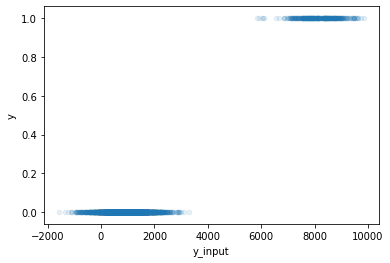

In [1170]:
fold_num = 1
train_data = create_y_merge_df('train', fold_num)
train_data[['y', 'y_input']].plot.scatter('y_input', 'y', alpha=0.1)

In [1193]:
test_data['pred'] = model_dict['Logistic Ridge'].predict(test_data[['y_input']])

In [1199]:
sum(test_data['pred'])

0

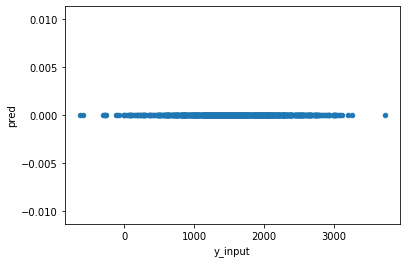

In [1198]:
test_data.plot.scatter('y_input', 'pred')

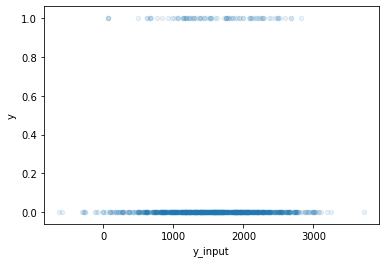

In [1171]:
test_data = create_y_merge_df('test', fold_num)
test_data[['y', 'y_input']].plot.scatter('y_input', 'y', alpha=0.1)

In [1157]:
len(test_data[test_data['y']==0]), len(test_data[test_data['y']==1])

(905, 95)

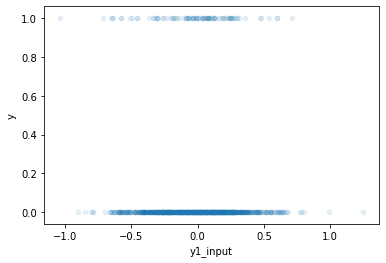

In [881]:
test_data[['y', 'y1_input']].plot.scatter('y1_input', 'y', alpha=0.1)

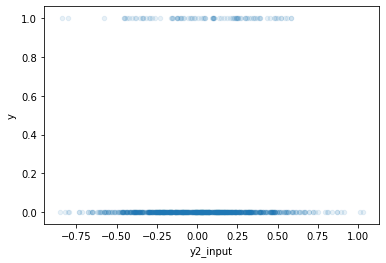

In [882]:
test_data[['y', 'y2_input']].plot.scatter('y2_input', 'y', alpha=0.1)

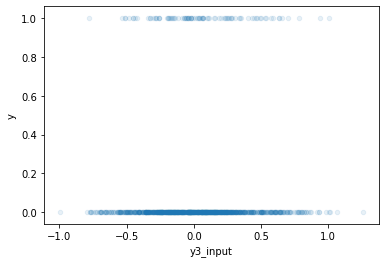

In [883]:
test_data[['y', 'y3_input']].plot.scatter('y3_input', 'y', alpha=0.1)

In [802]:
# Create merge df
train_data = create_y_merge_df('train', fold_num)
test_data = create_y_merge_df('test', fold_num)

In [803]:
# Normalize
for col in ('y_input', 'y1_input', 'y2_input', 'y3_input'):
    scaler = normalize(train_data, col)
    normalize(test_data, col, scaler)

In [804]:
# Split
X_train = train_data[['y1_input', 'y2_input', 'y3_input']]
#X_train = train_data[['y_input']]
y_train = train_data[['y']]
X_test = test_data[['y1_input', 'y2_input', 'y3_input']]
#X_test = test_data[['y_input']]
y_test = test_data[['y']]

In [812]:
# Create model dict
model_dict = {
    'Logistic Ridge': LogisticRegression(penalty='l2', solver='saga', random_state=random_seed),
    'Logistic Lasso': LogisticRegression(penalty='l1', solver='saga', random_state=random_seed),
    'Random Forest': RandomForestClassifier(random_state=random_seed),
    'Gradient Boost': GradientBoostingClassifier(random_state=random_seed),
    'SVM linear': SVC(kernel='linear', random_state=random_seed),
    'SVM rbf': SVC(random_state=random_seed1)
}

In [813]:
train_result, test_result, model_list =analyze_model_dict(model_dict, X_train, X_test, y_train, y_test)

Model: Logistic Ridge
@ Train scores
@ Test scores
train_acc: 0.9997500624843789, test_acc: 0.919
train_score: (array([1.        , 0.99719101]), array([0.99972573, 1.        ]), array([0.99986284, 0.99859353]), array([3646,  355]))
test_score: (array([0.919, 0.   ]), array([1., 0.]), array([0.95779052, 0.        ]), array([919,  81]))
Model: Logistic Lasso


/bin2/pkg_python36/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/bin2/pkg_python36/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/bin2/pkg_python36/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/bin2/pkg_python36/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home2/jpark/.virtualenvs/jupyter/local/lib/python3.6/site-packa

@ Train scores
@ Test scores
train_acc: 0.9997500624843789, test_acc: 0.918
train_score: (array([1.        , 0.99719101]), array([0.99972573, 1.        ]), array([0.99986284, 0.99859353]), array([3646,  355]))
test_score: (array([0.91891892, 0.        ]), array([0.99891186, 0.        ]), array([0.95724713, 0.        ]), array([919,  81]))
Model: Random Forest
@ Train scores
@ Test scores
train_acc: 1.0, test_acc: 0.919
train_score: (array([1., 1.]), array([1., 1.]), array([1., 1.]), array([3646,  355]))
test_score: (array([0.919, 0.   ]), array([1., 0.]), array([0.95779052, 0.        ]), array([919,  81]))
Model: Gradient Boost


/bin2/pkg_python36/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/bin2/pkg_python36/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


@ Train scores
@ Test scores
train_acc: 1.0, test_acc: 0.919
train_score: (array([1., 1.]), array([1., 1.]), array([1., 1.]), array([3646,  355]))
test_score: (array([0.919, 0.   ]), array([1., 0.]), array([0.95779052, 0.        ]), array([919,  81]))
Model: SVM linear
@ Train scores
@ Test scores
train_acc: 0.9995001249687578, test_acc: 0.917
train_score: (array([1.        , 0.99439776]), array([0.99945145, 1.        ]), array([0.99972565, 0.99719101]), array([3646,  355]))
test_score: (array([0.91883768, 0.        ]), array([0.99782372, 0.        ]), array([0.95670318, 0.        ]), array([919,  81]))
Model: SVM rbf
@ Train scores
@ Test scores
train_acc: 0.08872781804548863, test_acc: 0.081
train_score: (array([0.        , 0.08872782]), array([0., 1.]), array([0.        , 0.16299357]), array([3646,  355]))
test_score: (array([0.   , 0.081]), array([0., 1.]), array([0.        , 0.14986124]), array([919,  81]))


/bin2/pkg_python36/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/bin2/pkg_python36/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/bin2/pkg_python36/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/bin2/pkg_python36/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=0).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/bin2/pkg_python36/sklearn/metrics/_cla